In [43]:
# used to reload the imported modules on save
%load_ext autoreload
%autoreload 2

import utils as u

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import yaml
import cv2
import os

In [45]:
# constants
grid_size = (10,17)
square_size = 15

# getting the images path
images_pathname = "../our_calibration_images/"
images_path = [os.path.join(images_pathname, imagename) for imagename in os.listdir(images_pathname) if imagename.endswith(".jpg")]

# Sorting the lists of strings in numerical order
images_path.sort(key=lambda x: int(x.split('-WA')[-1].split('.')[0]))


## Exercise 1

In [46]:
V = []
all_H = []  # saving the homographies for each image

# getting the homographies
for img in images_path:
    _, H = u.get_homography(img, grid_size, square_size)
    all_H.append(H)
    
    v_12 = u.get_v_vector(H, 1, 2)
    v_11 = u.get_v_vector(H, 1, 1)
    v_22 = u.get_v_vector(H, 2, 2)
    
    V.append(v_12)
    V.append(v_11 - v_22)
    
# computing params
V = np.array(V)
K = u.get_intrinsic(V)

# computing extrinsic for one image
all_R = []
all_t = []

for H in all_H:
    R, t = u.get_extrinsic(K, H)
    all_R.append(R)
    all_t.append(t)

# TODO: make a better log
print("Example params: \n")
print(f"- K -\n{K}\n")
print(f"- R -\n{all_R[0]}\n")
print(f"- t - \n{all_t[0]}\n")


Example params: 

- K -
[[1.27778742e+03 2.85606848e+00 7.99558141e+02]
 [0.00000000e+00 1.27238599e+03 5.53412839e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

- R -
[[-0.99461104  0.0534593  -0.08883116]
 [ 0.06009348  0.99546326 -0.07376773]
 [ 0.08448458 -0.07870837 -0.9933113 ]]

- t - 
[166.40437403 -72.76334119 401.90476649]



## Exercise 2

In [47]:
old_w, old_h = 1600, 1200
new_w, new_h = 1280, 720
sx = new_w / old_w
sy = new_h / old_h

K_scaled = K.copy()
K_scaled[0, 0] *= sx  # fx
K_scaled[1, 1] *= sy  # fy
K_scaled[0, 2] *= sx  # u0
K_scaled[1, 2] *= sy  # v0

viz_img_index = 0 
projected_corners_viz = []
image_to_show = None
total_sum_error = 0.0

for i in range(len(all_H)):
    img_path = images_path[i]
    P = u.get_projection_matrix(K_scaled, all_R[i], all_t[i])

    try:
        corners_orig = u.get_corners(img_path, grid_size)
    except Exception:
        continue

    grid_size_cv2 = tuple(reversed(grid_size))
    
    for index, corner in enumerate(corners_orig):

        u_coord = corner[0] * sx 
        v_coord = corner[1] * sy
        
        u_index, v_index = np.unravel_index(index, grid_size_cv2)
        point_m = np.array([u_index * square_size, v_index * square_size, 0, 1])

        projected_u, projected_v = u.project(point_m, P)[0]
        
        error += (projected_u - u_coord)**2 + (projected_v - v_coord)**2
        total_corners_count += 1

        if i == viz_img_index:
            projected_corners_viz.append((projected_u, projected_v))


if total_corners_count > 0:
    print(f"Total error (all images): {error:.2f}")
    print(f"Mean error per corner (total): {error/total_corners_count:.4f}")


raw_img = cv2.imread(images_path[viz_img_index])
# Important: the image must be resized to match K_scaled and the points.
img_resized = cv2.resize(raw_img, (new_w, new_h))
image_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

for cp in projected_corners_viz:
    cv2.circle(image_rgb, (int(cp[0]), int(cp[1])), radius=3, color=(255, 0, 0), thickness=-1)

px.imshow(image_rgb)

Total error (all images): 37097.00
Mean error per corner (total): 1.2123


In [48]:
import numpy as np
import cv2

# Resizing Parameters and Scale Factorsto match Professor's resolution (1280x720)
old_w, old_h = 1600, 1200
new_w, new_h = 1280, 720
sx = new_w / old_w
sy = new_h / old_h

# Adaptation of the K matrix (scaled once only)
K_scaled = K.copy()
K_scaled[0, 0] *= sx  # fx
K_scaled[1, 1] *= sy  # fy
K_scaled[0, 2] *= sx  # u0
K_scaled[1, 2] *= sy  # v0


total_sum_squared_error = 0
total_corners_processed = 0



for i in range(len(all_H)):
    img_path = images_path[i]
    R_i = all_R[i]
    t_i = all_t[i]

    P = u.get_projection_matrix(K_scaled, R_i, t_i)

    try:
        corners_orig = u.get_corners(img_path, grid_size)
    except Exception:
        continue

    grid_size_cv2 = tuple(reversed(grid_size))
    
    for index, corner in enumerate(corners_orig):

        # resized corner coordinates
        u_coord_resized = corner[0] * sx 
        v_coord_resized = corner[1] * sy
        
        u_index, v_index = np.unravel_index(index, grid_size_cv2)
        x_mm = u_index * square_size
        y_mm = v_index * square_size
        point_m = np.array([x_mm, y_mm, 0, 1])

        projected_u, projected_v = u.project(point_m, P)[0]
        
        total_sum_squared_error += (projected_u - u_coord_resized)**2 + (projected_v - v_coord_resized)**2
        total_corners_processed += 1

if total_corners_processed > 0:
    mean_error_total = total_sum_squared_error / total_corners_processed
    rmse_total = np.sqrt(mean_error_total) 
    
  
    print(f"Total Mean Squared Error: {mean_error_total:.4f}")
    print(f"Mean Reprojection Error (RMSE): {rmse_total:.4f} pixel")
    print("-" * 30)
else:
    print("Errore: Nessun corner processato.")


# showing the projected corners
image = cv2.imread(img_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # type: ignore

for corner in projected_corners:
    u_coord, v_coord = int(corner[0]), int(corner[1])
    cv2.circle(image_rgb, (u_coord, v_coord), radius=5, color=(255, 0, 0), thickness=-1)

px.imshow(image_rgb)

Total Mean Squared Error: 1.2054
Mean Reprojection Error (RMSE): 1.0979 pixel
------------------------------


### Exercise 3

In [49]:
import random

random.seed(0)
NUM_IMAGES_TO_PROCESS = 25

images_indices = random.sample(range(len(images_path)), NUM_IMAGES_TO_PROCESS)

# 3D parameters of the cylinder (remain fixed for all projections)
radius_mm = 22.0
height_mm = 80.0

# Positioning consistent with the origin of the checkerboard (e.g. 4 squares, 4 squares)
center_x_mm = 5 * square_size 
center_y_mm = 4 * square_size
num_sides_cyl = 30 # Cylinder resolution
num_height_slices_cyl = 5

superimposed_image_list = []

for i in images_indices:
    img_path = images_path[i]
    R_i = all_R[i]
    t_i = all_t[i]
    P = u.get_projection_matrix(K, R_i, t_i)
    
    superimposed_image = u.superimpose_cylinder(
        img_path=img_path, 
        P=P,
        radius=radius_mm, 
        height=height_mm, 
        center_x=center_x_mm, 
        center_y=center_y_mm,
        num_sides=num_sides_cyl,
        num_height_slices=num_height_slices_cyl
    )
    
    superimposed_image_list.append(superimposed_image)
    
px.imshow(superimposed_image_list[0])

### Exercise 4

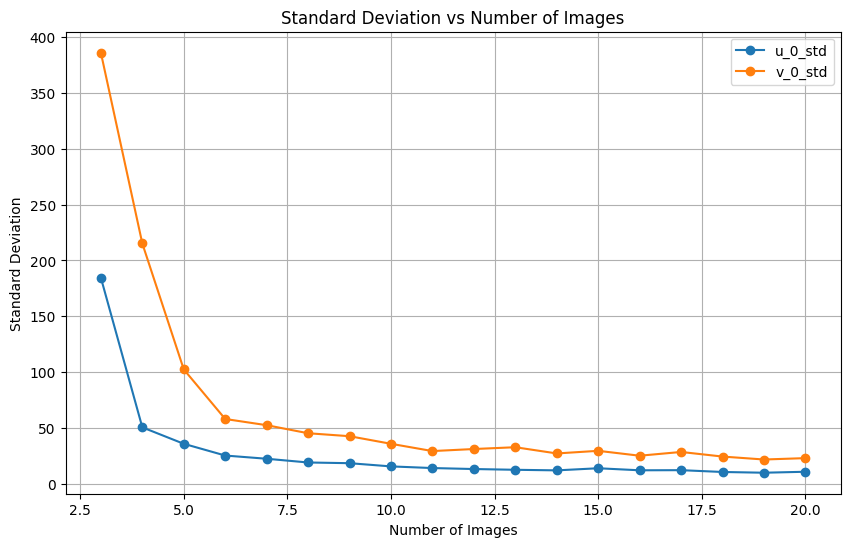

In [50]:
random.seed(0)
max_N_images = 20
N_images = list(range(3, max_N_images + 1))
n_samples = 100

# since V is a stack of two equations per image,
# I can use them to compute K instead of recomputing V each time
index_to_select = list(range(0, len(V), 2))

u0_std = []
v0_std = []

for n_images in range(3, max_N_images + 1):
    current_sample = 1
    principal_point_coord = []
    while current_sample <= n_samples:
        selected_images = np.array(random.sample(index_to_select, n_images))
        _V = np.concatenate([V[selected_images], V[selected_images + 1]])

        # some matrices could be not positive definite -> no solution
        try:
            K = u.get_intrinsic(np.array(_V))
        except:
            continue
        
        principal_point_coord.append([K[0,2], K[1,2]])
        current_sample += 1
    
    principal_point_coord = np.stack(principal_point_coord)
    _u0_std, _v0_std = principal_point_coord.std(axis=0)
    u0_std.append(_u0_std.item())
    v0_std.append(_v0_std.item())
    
plt.figure(figsize=(10, 6))
plt.plot(N_images, u0_std, marker='o', label='u_0_std')
plt.plot(N_images, v0_std, marker='o', label='v_0_std')
plt.xlabel('Number of Images')
plt.ylabel('Standard Deviation')
plt.title('Standard Deviation vs Number of Images')
plt.grid(True)
plt.legend()
plt.show()